In [1]:
from utils import *
from dataset import *
from autoencoder import *

Ashley = False
if Ashley:
    device = "cpu"
else:
    device = "cuda"

In [2]:
#### Load true and false flares data
# Load dataframes
true_flares_df = pd.read_csv('../Chandra_data/trueflares.csv')
false_flares_df = pd.read_csv('../Chandra_data/falseflares.csv')
true_flares_df = true_flares_df[['time','energy','obsreg_id']]
false_flares_df = false_flares_df[['time','energy','obsreg_id']]

# Convert to data dictionary
d = true_flares_df.groupby('obsreg_id').apply(lambda group: np.array(group[['time', 'energy']])).to_dict()
d.update(false_flares_df.groupby('obsreg_id').apply(lambda group: np.array(group[['time', 'energy']])).to_dict())

In [3]:
# Prepare for data, drop the outliers
data_lst = []
lengths = []
Ts = []
length_threshold = 5000
T_threshold = 250000
for key in list(d.keys()):
    length = len(d[key])
    T = max(d[key][:,0]) - min(d[key][:,0])
    if length > length_threshold or T > T_threshold:
        continue
    else:
        lengths.append(length)
        Ts.append(T)
        data_lst.append({'event_list':d[key]})

B = 8
data = RealEventsDataset(data_lst,t_scale=5000)
loader = DataLoader(data, batch_size=B, shuffle=True, num_workers=4, collate_fn=padding_collate_fn)
lengths = np.array(lengths)
Ts = np.array(Ts)

In [7]:
# # Visualization
# fig, ax = plt.subplots(1,2)
# ax[0].hist(lengths,bins=20);
# ax[0].set_title('Event list lengths')

# ax[1].hist(Ts,bins=20);
# ax[1].set_title('Event list time range')
# plt.tight_layout()

In [4]:
# Create NN model
num_freqs = 12
num_latent = 128
E_bins = 13
encoding = PositionalEncoding(num_freqs=num_freqs)
model = AutoencoderTransformer(num_latent, encoding, hidden_size=256, E_bins=E_bins, lam_TV=0.3, lam_latent=0)
trainer = pl.Trainer(max_epochs=100, 
                     accelerator=device, 
                     devices=1, 
                     plugins=[DisabledSLURMEnvironment(auto_requeue=False)], 
                     log_every_n_steps=2)
history = trainer.fit(model, loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nobackup/users/yankeson/miniconda3/envs/DL/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /nobackup/users/yankeson/ppae/lightning_logs/version_370711/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | code    | PositionalEncoding | 0     
1 | encoder | TransformerEncoder | 18.2 K
2 | decoder | ResnetFC           | 120 K 
-----------------------------------------------
138 K     Trainable params
0         Non-trainable params
138 K     Total params
0.555     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
# Plot training loss (there were some issues with tensorboard)
!tensorboard --logdir lightning_logs/

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.1 at http://localhost:6006/ (Press CTRL+C to quit)


In [5]:
# Test data, currently just the training data
test_loader = DataLoader(data, batch_size=B, collate_fn=padding_collate_fn)
test_batch = next(iter(test_loader))
model.to(device);
with torch.no_grad():
    temp = model.code(test_batch['event_list'].to(device))
    model.encode(model.code(test_batch['event_list'].to(device)), ~(test_batch['mask'].to(device)))
    z = model.latent.cpu().numpy()

In [6]:
# Visualize the rate function that the NN has learned.
with torch.no_grad():
    coded = model.code(test_batch['event_list'].to(device))
    rates = model.decode(coded[:,:,:-E_bins])
    coded = coded.cpu()
    rates = rates.cpu()

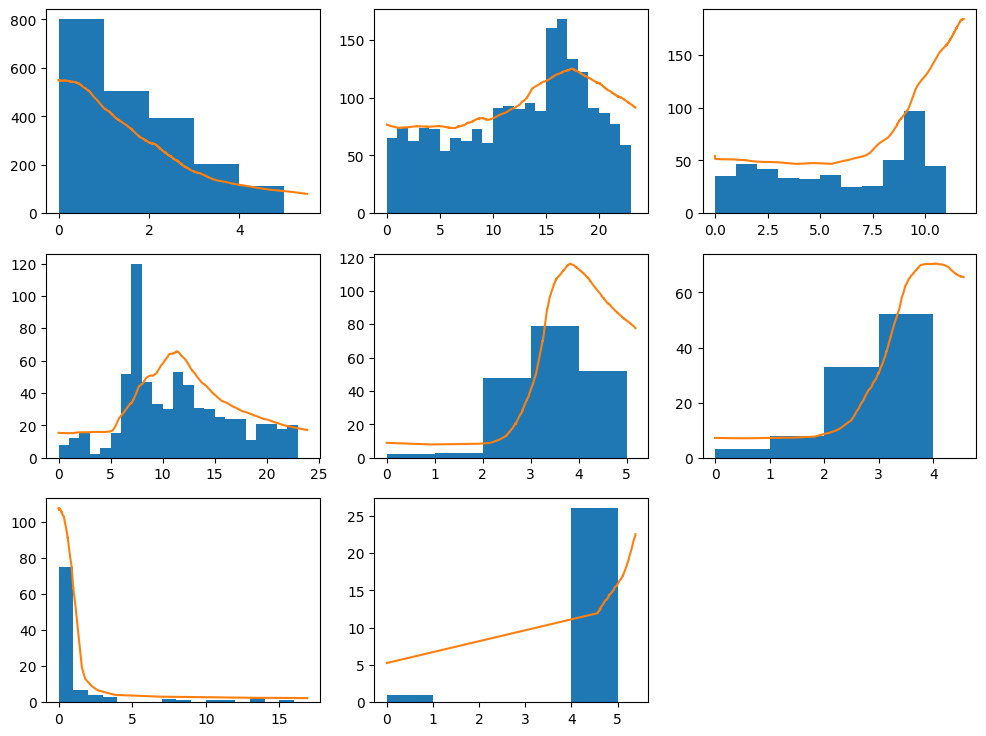

In [12]:
# Plot total rates


plt.figure(figsize=(12,9))
start_index = 0
for i in range(8):
    index = start_index + i
    masks = test_batch['mask']

    times = coded[index,masks[index],0]
    plt.subplot(3,3,i+1)
    plt.hist(times, bins = torch.arange(torch.ceil(torch.max(times))))
    plt.plot(times, torch.sum(torch.exp(rates[index,masks[index],:]),dim=-1))

plt.show()

# Plot rates for a specific energy bin
# plt.figure(figsize=(12,9))
# start_index = 0
# for i in range(8):
#     index = start_index + i
#     E_index = 0
#     masks = test_batch['mask']
#     valid_times = coded[index,masks[index]]
#     E_mask = valid_times[:,E_index+2*num_freqs+1]==1
#     times = valid_times[E_mask,0]
    
#     plt.subplot(3,3,i+1)
#     plt.hist(times, bins = torch.arange(torch.ceil(torch.max(times))))
#     valid_rates = rates[index,masks[index],E_index]
#     plt.plot(times, torch.exp(valid_rates[E_mask]))
# plt.show()